# **Sale Price prediction**

## Objectives

* Fit and evaluate a regression model to predict the Sale Price of a house in Ames, Iowa.

## Inputs

* outputs/datasets/collection/house_prices_records.csv
* instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.


## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipelne
* 
Modeling pipin
* 
Feature importance plot

---

# Change working directory

In [1]:
import numpy
import os

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

Change the working directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

---

# Load Data

Irrelevant variables where dropped in this process

In [5]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_price_records.csv")
     .drop(labels=['EnclosedPorch', 'WoodDeckSF', '1stFlrSF', 'GarageYrBlt', 'GrLivArea', 'YearRemodAdd'],axis=1))
df.head()

,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,SalePrice
0,854.0,3.0,No,706,GLQ,150,548,RFn,Gd,8450,65.0,196.0,61,5,7,856,2003,208500
1,0.0,3.0,Gd,978,ALQ,284,460,RFn,TA,9600,80.0,0.0,0,8,6,1262,1976,181500
2,866.0,3.0,Mn,486,GLQ,434,608,RFn,Gd,11250,68.0,162.0,42,5,7,920,2001,223500
3,NaN,NaN,No,216,ALQ,540,642,Unf,Gd,9550,60.0,0.0,35,5,7,756,1915,140000
4,NaN,4.0,Av,655,GLQ,490,836,RFn,Gd,14260,84.0,350.0,84,5,8,1145,2000,250000


# ML Pipeline with all Data

## ML pipeline for Data Cleaning and Feature Engineering

In [6]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer

### Feature Engineering
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
def PipelineDataCleaningFeatureEngineering(model):
    pipeline_base = Pipeline([
        
        # Data Cleaning 
        ("mean", MeanMedianImputer(imputation_method='mean', variables=['BedroomAbvGr', 'GarageArea', 'LotFrontage'])),

        ("median", MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea'])),

        ("categorical", CategoricalImputer(imputation_method='missing', fill_value='None', variables=['GarageFinish', 'BsmtFinType1'])),

        # Feature Engineering
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("lt", vt.LogTransformer(variables = ['LotArea'])),

        ("pt", vt.PowerTransformer(variables = ['LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '2ndFlrSF'])),

        ("winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables = ['LotArea', 'GarageArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '2ndFlrSF'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler() ),

        ("feat_selection", SelectFromModel(model) ),

        ("model", model ),
        ])

    return pipeline_base

## Pipeline for Modelling and Hyperparameter Optimisation

In [8]:
# Code taken from walktrough Project 02 - Churnometer
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineDataCleaningFeatureEngineering(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [9]:
# Code taken & modified from walktrough Project 02 - Churnometer
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 17) (1168,) 
* Test set: (292, 17) (292,)


## Grid Search CV: Sklearn

Use hyperparameters to find most suitable algorithm

In [10]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LinearRegression": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Check Train Set Target distribution

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Check Results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.642091,0.760898,0.814892,0.065758
2,RandomForestRegressor,0.650979,0.757848,0.827038,0.058833
5,GradientBoostingRegressor,0.5777,0.731159,0.838798,0.086225
0,LinearRegression,0.650038,0.708335,0.763414,0.043754
4,AdaBoostRegressor,0.507286,0.669608,0.743537,0.084233
6,XGBRegressor,0.559256,0.639401,0.71902,0.061418
1,DecisionTreeRegressor,0.390321,0.498924,0.662402,0.092574


## Extensive Search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [13]:
# These configurations were obtained from Code Institute Scikit-Learn Unit 6:
models_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    "LinearRegression": {},
    "DecisionTreeRegressor": {'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
    
    "RandomForestRegressor": {'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
    
    "ExtraTreesRegressor": {'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
    },
    
    "AdaBoostRegressor": {'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                          'model__loss':['linear', 'square', 'exponential'],
    },
    
    "GradientBoostingRegressor": {'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
    },
    
    "XGBRegressor": {'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
    },
}

Extensive GridSearch CV - Binary Classifier

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

Check results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
99,ExtraTreesRegressor,0.646292,0.762769,0.815627,0.065488,None,NaN,1,2,150,NaN,NaN,NaN
123,ExtraTreesRegressor,0.642929,0.761928,0.81712,0.068315,15,NaN,1,2,150,NaN,NaN,NaN
98,ExtraTreesRegressor,0.65002,0.761164,0.813957,0.064075,None,NaN,1,2,50,NaN,NaN,NaN
97,ExtraTreesRegressor,0.642091,0.760898,0.814892,0.065758,None,NaN,1,2,100,NaN,NaN,NaN
121,ExtraTreesRegressor,0.641729,0.759792,0.816222,0.068252,15,NaN,1,2,100,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,XGBRegressor,-6.296405,-5.096922,-4.398517,0.639598,3,NaN,NaN,NaN,30,0.001,NaN,0.1
430,XGBRegressor,-6.296193,-5.09696,-4.397257,0.639758,None,NaN,NaN,NaN,30,0.001,NaN,0.1
403,XGBRegressor,-6.296193,-5.09696,-4.397257,0.639758,None,NaN,NaN,NaN,30,0.001,NaN,0
409,XGBRegressor,-6.296889,-5.097065,-4.397257,0.640031,15,NaN,NaN,NaN,30,0.001,NaN,0


Get best model name programmatically

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

Define the best clf pipeline

In [18]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['BedroomAbvGr', 'GarageArea',
                                              'LotFrontage'])),
                ('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'MasVnrArea'])),
                ('categorical',
                 CategoricalImputer(fill_value='None',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbi...
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'KitchenQual', 'LotArea',
                                                     'Lo

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['GarageArea', 'TotalBsmtSF', 'YearBuilt', 'KitchenQual', '2ndFlrSF']


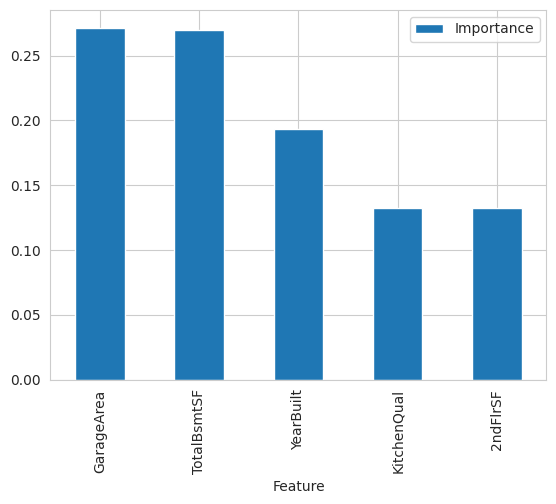

In [19]:
# These configurations were obtained from Code Institute Scikit-Learn Unit 6:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

data_cleaning_feat_eng_steps = 8
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()].to_list()

df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
          'Importance': pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")


df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets

* It meets the project requirement for at least 0.75 R2 score on the train and test sets.

In [20]:
# These configurations were obtained from Code Institute Scikit-Learn Unit 3:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  
  plt.show()

Evaluate performance

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 152.458
Mean Squared Error: 1014927.989
Root Mean Squared Error: 1007.436


* Test Set
R2 Score: 0.796
Mean Absolute Error: 23628.819
Mean Squared Error: 1409181195.385
Root Mean Squared Error: 37539.062




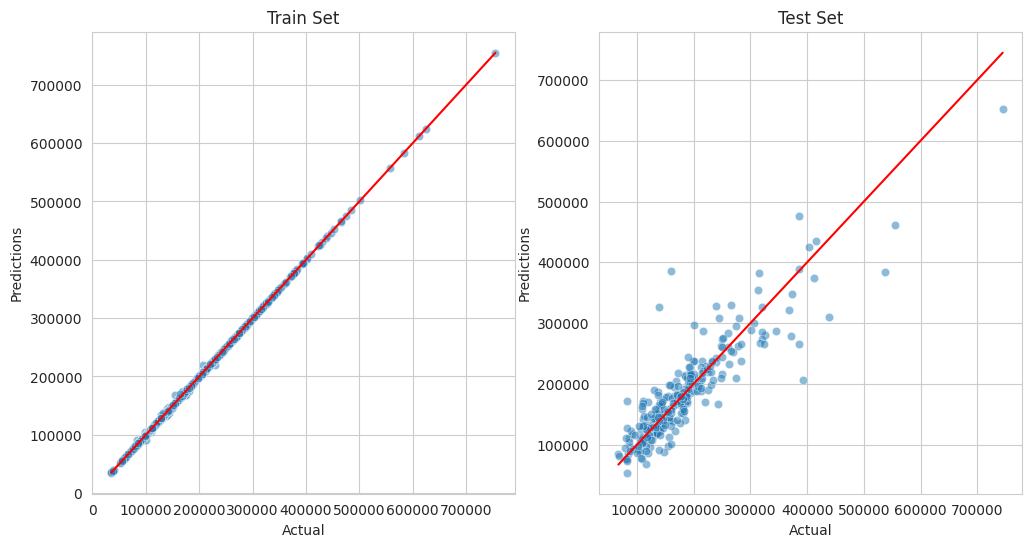

In [21]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_clf)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_clf)

## Refit pipeline with best features

In [22]:
best_features

['2ndFlrSF', 'GarageArea', 'KitchenQual', 'TotalBsmtSF', 'YearBuilt']

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [23]:
def PipelineDataCleaningFeatureEngineering(model):
    pipeline_base = Pipeline([
        
        # Data Cleaning 

        ("mean", MeanMedianImputer(imputation_method='mean', variables=['GarageArea'])),
        
        ("median", MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF'])),

        # Feature Engineering

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['KitchenQual'])),

        ("pt", vt.PowerTransformer(variables = ['TotalBsmtSF', '2ndFlrSF'])),

        ("winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables = ['TotalBsmtSF', '2ndFlrSF'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler() ),

        ("model", ExtraTreesRegressor(n_estimators=150, random_state=0) ),
        ])

    return pipeline_base

## Split Train Test Set, considering only with best features

In [24]:
# Code taken & modified from walktrough Project 02 - Churnometer
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 17) (1168,) (292, 17) (292,)


I filter only the most important variables

In [25]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 5) (1168,) (292, 5) (292,)


,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt
618,0.0,774,Gd,1822,2007
870,0.0,308,TA,894,1962
92,0.0,432,TA,876,1921


## Grid Search CV - Sklearn

Same from previous GridCV search

In [32]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [33]:
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [36]:
params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [140],
                          'model__max_depth': [None],
                          'model__max_leaf_nodes': [None],
                          'model__min_samples_split': [2],
                          'model__min_samples_leaf': [1],
                            }
}
params_search

{'ExtraTreesRegressor': {'model__n_estimators': [140],
  'model__max_depth': [None],
  'model__max_leaf_nodes': [None],
  'model__min_samples_split': [2],
  'model__min_samples_leaf': [1]}}

## GridSearch CV

In [37]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Check results

In [39]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.656248,0.759545,0.820036,0.064421,None,None,1,2,140


Define the best clf pipeline

In [40]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [41]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [42]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['GarageArea'])),
                ('median', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('pt', PowerTransformer(variables=['TotalBsmtSF', '2ndFlrSF'])),
                ('winsorizer',
                 Winsorizer(capping_method='..., fold=1.5, tail='both',
                            variables=['TotalBsmtSF', '2ndFlrSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['2ndFlrSF', 'GarageArea',
                                              

# Push files to the repo

I will generate the following files

* Train Set
* Test Set
* Modeling pipeline
* Features importance plot


In [44]:
import joblib
import os

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

In [45]:
X_train.head()

,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt
618,0.0,774,Gd,1822,2007
870,0.0,308,TA,894,1962
92,0.0,432,TA,876,1921
817,0.0,857,Gd,1568,2002
302,0.0,843,Gd,1541,2001


In [46]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [47]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [48]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

In [49]:
X_test.head()

,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt
529,0.0,484,TA,2035,1957
491,620.0,240,Fa,806,1941
459,224.0,352,Gd,709,1950
279,866.0,505,TA,1160,1977
655,NaN,264,TA,525,1971


In [50]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [51]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [52]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modeling Pipeline

In [53]:
pipeline_clf

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['GarageArea'])),
                ('median', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('pt', PowerTransformer(variables=['TotalBsmtSF', '2ndFlrSF'])),
                ('winsorizer',
                 Winsorizer(capping_method='..., fold=1.5, tail='both',
                            variables=['TotalBsmtSF', '2ndFlrSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['2ndFlrSF', 'GarageArea',
                                              

In [54]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/pipeline_clf.pkl")

['outputs/ml_pipeline/predict_churn/v2/pipeline_clf.pkl']

## Feature importance plot

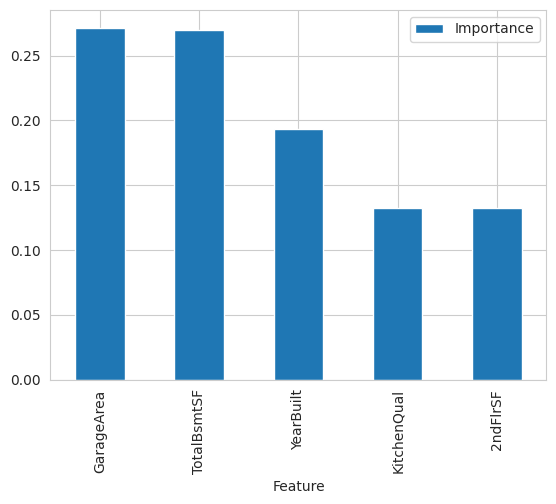

In [55]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

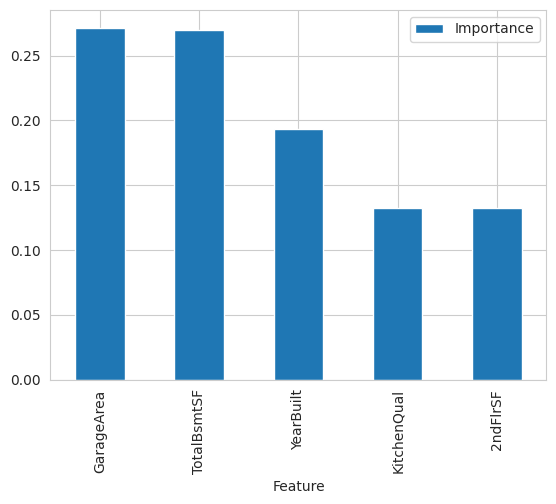

In [56]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

# Conclusions

* The feature performance plot shows that varibales related to age of the property and size have a high predictive influence.

* Hypothesis:
  * Original construction date is very important: "YearBuilt"
  * size matters: "TotalBsmtSF", "2ndFlrSF" & "GarageArea"
  * Kitchen Quality matters